In [123]:
import numpy as np
import torch
from torch.autograd import Variable
import torch.optim as optim
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from quimb import *
from quimb.tensor import *
import sympy as sym

import scipy as sp
from scipy import linalg

from Fredkin_functions import *

## Dynamics generated by $H = \sigma^- a^\dagger + h.c $

* Unitary generated by this hamiltonian is $$U(t) = \begin{pmatrix} \cos(t \sqrt{n+1}) & i a \sqrt{n}^{-1}\sin(t\sqrt{n}) \\
ia^\dagger \sqrt{n+1}^{-1} \sin(t\sqrt{n+1}) &  \cos(t \sqrt{n})\end{pmatrix}$$

* Some examples of the dynamics this generates are:
\begin{align}
&U: \ket{0}\otimes \ket{n} \to \cos(t\sqrt{n+1})\ket{0}\otimes \ket{n} + i\sin(t\sqrt{n+1})\ket{1}\otimes \ket{n+1} \\
& U: \ket{1}\otimes \ket{n} \to \cos(t\sqrt{n})\ket{1}\otimes \ket{n} + i\sin(t\sqrt{n})\ket{0} \otimes \ket{n-1}
\end{align}

### The first thing to look at is the MPS generated by the unitary with alternating 1 and 0 inputs:

$$U(t) = \begin{pmatrix} \cos(t \sqrt{n+1}) & i a \sqrt{n}^{-1}\sin(t\sqrt{n}) \\
ia^\dagger \sqrt{n+1}^{-1} \sin(t\sqrt{n+1}) &  \cos(t \sqrt{n})\end{pmatrix} = \begin{pmatrix} A^0 & B^0 \\
A^1 & B^1 \end{pmatrix}$$

Lets define a function with generates $A^i ~\& ~ B^i$ up to some maximum bond dimension

In [124]:
def JC_tensors(chi, t): #makes U above as a 4 tensor
    A0, A1, B0, B1 = [np.zeros((chi,chi), dtype = complex), np.zeros((chi,chi),dtype = complex), np.zeros((chi,chi),dtype = complex),np.zeros((chi,chi),dtype = complex)] 

    for n in range(chi-1):
        B1[n,n] = np.cos(t*np.sqrt(n))
        A1[n,n+1] = np.sin(t*np.sqrt(n+1))

        B0[n+1,n] = np.sin(t*np.sqrt(n+1))
        A0[n,n] = np.cos(t*np.sqrt(n+1))

    B1[-1,-1] = np.cos(t*np.sqrt(chi-1))
    B0[-1,-2] = np.sin(t*np.sqrt(chi-1))#this may be wrong

    A1[-2,-1] = np.sin(t*np.sqrt(chi-1))
    A0[-1,-1] = np.cos(t*np.sqrt(chi))
    # need to adjust bottom right corner of B0 and A1 further to make rotor-like unitary

    U = np.zeros((2,2,chi,chi), dtype = complex) #Tensor U_ijnm (2,2,chi,chi)
    U[0,0], U[1,0], U[0,1], U[1,1] = [A0, 1j*A1, 1j*B0, B1]

    return U

def MPS_JC_2site(chi,t): # makes MPS for 2 site unit cell
    U = JC_tensors(chi,t)
    A0,A1,B0,B1 = [U[0,0], U[1,0], U[0,1], U[1,1]] # standard single site MPS tensors

    C = np.zeros((4,chi,chi), dtype = complex) #0 = 00, 1 = 01, 2 = 10, 3 = 11
    C[0], C[1], C[2], C[3] = [np.einsum('ij,jk', A0, B0), np.einsum('ij,jk', A0, B1), np.einsum('ij,jk', A1, B0), np.einsum('ij,jk', A1, B1)]

    return C

# Stochastic Matrix M:
$p_j = M p_{j-1}$ where $p_j$ is a column vector which tells me the probablility of being in state $n$ at time $j$

* Lets consider a 2 site unit cell where we input qubits $\ket{01}$ and then evolve for two steps with the photon. One can show that the stochastic matrix which desbribes the qubit evolution is given by the following: 

$$ \begin{align} 
    M_{mn}(t) = [\big(\cos{t\sqrt{n+1}}\cos{t\sqrt{n}}\big)^2 &+ \big(\sin{t\sqrt{n+1}}\big)^4]\delta_{mn}\\  + \big(\cos{t\sqrt{n+1}}&\sin{t\sqrt{n}})^2\delta_{m,n-1} \\ &+ \big(\cos{t\sqrt{n+1}}\sin{t\sqrt{n+1}})^2\delta_{m,n+1}
\end{align}$$

In [127]:
def M_stoch(chi,t): 
    M = np.zeros((chi,chi))

    for n in np.arange(chi):
        M[n, n] = (np.cos(t*np.sqrt(n+1))* np.cos(t*np.sqrt(n)))**2 + np.sin(t*np.sqrt(n+1))**4
        
        if n > 0:
            M[n-1,n] = (np.cos(t*np.sqrt(n+1))* np.sin(t*np.sqrt(n)))**2
        if n < chi-1:
            M[n+1,n] = (np.cos(t*np.sqrt(n+1))* np.sin(t*np.sqrt(n+1)))**2
        
    #modify M[chi-1,chi-1] so that sum of chi'th column =1
    M[-1,-1] += 1- M[:,chi-1].sum()

    return M

def Hop_prob(n, t):
    S = (np.cos(t*np.sqrt(n+1))* np.cos(t*np.sqrt(n)))**2 + np.sin(t*np.sqrt(n+1))**4
    L = (np.cos(t*np.sqrt(n+1))* np.sin(t*np.sqrt(n)))**2
    R = (np.cos(t*np.sqrt(n+1))* np.sin(t*np.sqrt(n+1)))**2

    return L, S, R
    

def M_randwalk(chi, p):
    M = np.zeros((chi,chi))

    for n in np.arange(chi):
        M[n, n] = 1-2*p
        
        if n > 0:
            M[n-1,n] = p
        if n < chi-1:
            M[n+1,n] = p

    M[0,0] = 1-p
        
    #modify M[chi-1,chi-1] so that sum of chi'th column =1
    M[-1,-1] += 1- M[:,chi-1].sum()

    return M

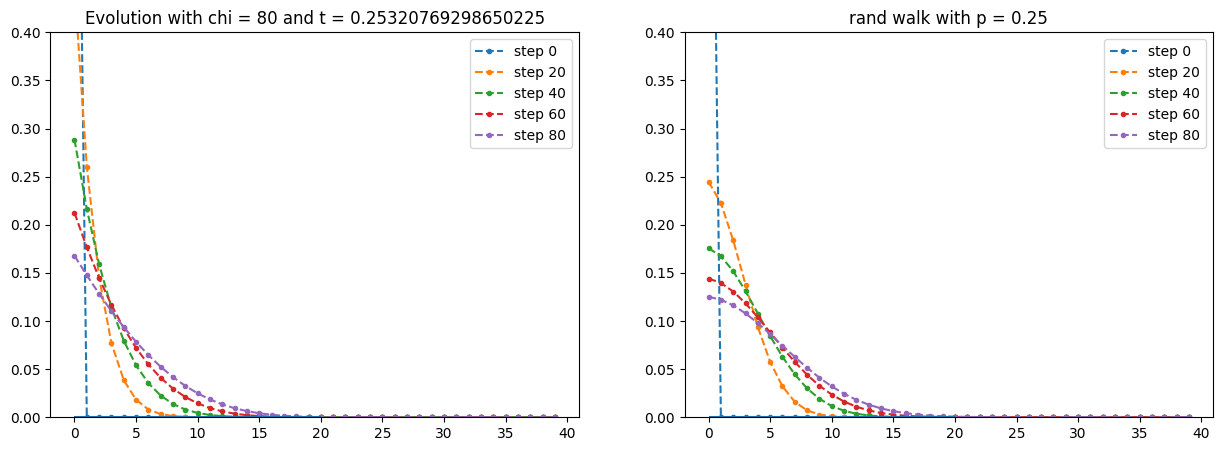

In [154]:
chi, t, p = [80, np.sqrt(np.pi)/7, .25]

M_F = M_randwalk(chi,p)
M = M_stoch(chi,t)
v0 = np.zeros(chi)
v0[0] = 1


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))

for n in range(0, 100, 20):
    ax1.plot((np.linalg.matrix_power(M,n) @ v0)[0:40], '.--', label = f'step {n}')
    ax2.plot((np.linalg.matrix_power(M_F,n) @ v0)[0:40], '.--', label = f'step {n}')
ax1.hlines(0,0, 20)
ax1.set_title(f'Evolution with chi = {chi} and t = {t}')
ax2.hlines(0,0, 20)
ax2.set_title(f'rand walk with p = {p}')
ax1.legend()
ax2.legend()

ax1.set_ylim(0, .4)
ax2.set_ylim(0, .4)
plt.show()

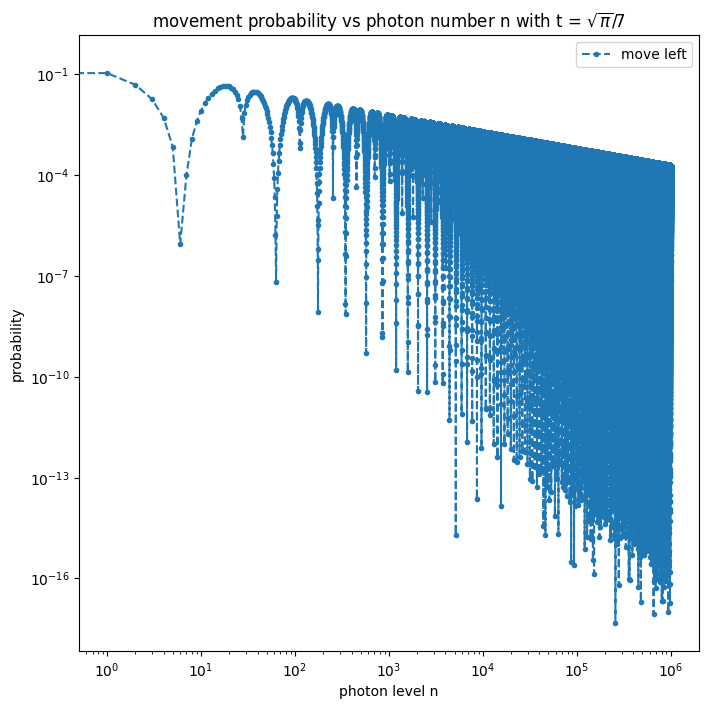

In [169]:
N,t = [10**6,np.sqrt(np.pi)/3]

L, S, R = [[], [],[]]
for n in range(N):
    P = Hop_prob(n,t)
    L.append(P[0])
    S.append(P[1])
    R.append(P[2])

plt.figure(figsize = (8,8))
plt.plot([np.abs(L[i]-R[i]) for i in range(len(L))],'.--', label = 'move left')
#plt.plot(S,'.--', label = 'stay')
#plt.plot(R,'.--', label = 'move right')
plt.xlabel('photon level n')
plt.ylabel('probability')
#plt.ylim(0, .1)
plt.yscale('log')
plt.xscale('log')

plt.title('movement probability vs photon number n with t = $\sqrt{\pi}/7$')

plt.legend()
plt.show()

Post selecting on 0

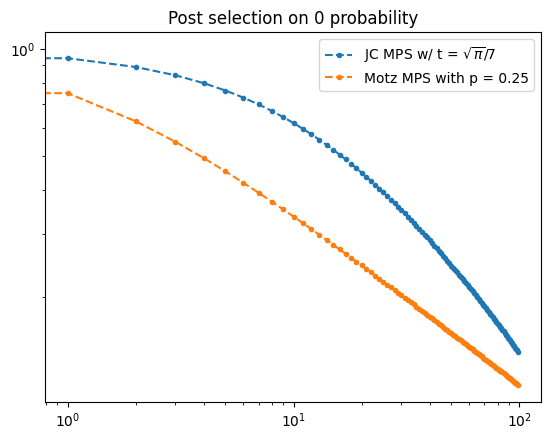

In [155]:
Post_sel0 =[(np.linalg.matrix_power(M_stoch(chi,t),n) @ v0)[0] for n in range(100)]
Post_sel0_Motz =[(np.linalg.matrix_power(M_F,n) @ v0)[0] for n in range(100)]
plt.plot(Post_sel0, '.--', label = 'JC MPS w/ t = $\sqrt{\pi}/7$')
plt.plot(Post_sel0_Motz, '.--', label = f'Motz MPS with p = {p}')
plt.xscale('log')
plt.yscale('log')
plt.title("Post selection on 0 probability")
plt.legend()
plt.show()

# Comparrison w/ Motzkin chain

In [131]:
def A_Motzkin(chi, pL, pR):
    Aplus, A0, Aminus = [np.zeros((chi,chi)),np.zeros((chi,chi)),np.zeros((chi,chi))]

    for n in range(chi):
        A0[n,n] = np.sqrt(1-pL-pR)
        if n<chi-1:
            Aplus[n+1,n] = np.sqrt(pR) 

        if n>0:
            Aminus[n-1,n] = np.sqrt(pL)

    Aplus[1,0] = np.sqrt(pL+pR)

    return Aplus, A0, Aminus

Lets see how S_E varies with chi for Motzkin.
* Note that we can do a relatively large system size with a conservative bond dimension.
* Naively we need $\chi = L/2$ but in reality a much smaller $\chi$ saturates $S_E$

In [132]:
pR, pL = [.25,.25]
L = 500
MPS_dict = {}
chi_data = np.arange(20, 56, 5).tolist()

for chi in chi_data:
    A_Motz = A_Motzkin(chi, pL,pR)
    BL = np.zeros((2, chi, chi))
    BL[0,0,0] = 1

    MPS_list = [A_Motz for i in range(L)]
    MPS_list.insert(0, BL)
    MPS_list.append(BL)

    Motz_MPS = MatrixProductState(MPS_list, shape = 'plr')
    Motz_MPS.cyclic = False
    Motz_MPS.normalize()

    MPS_dict[chi] = Motz_MPS

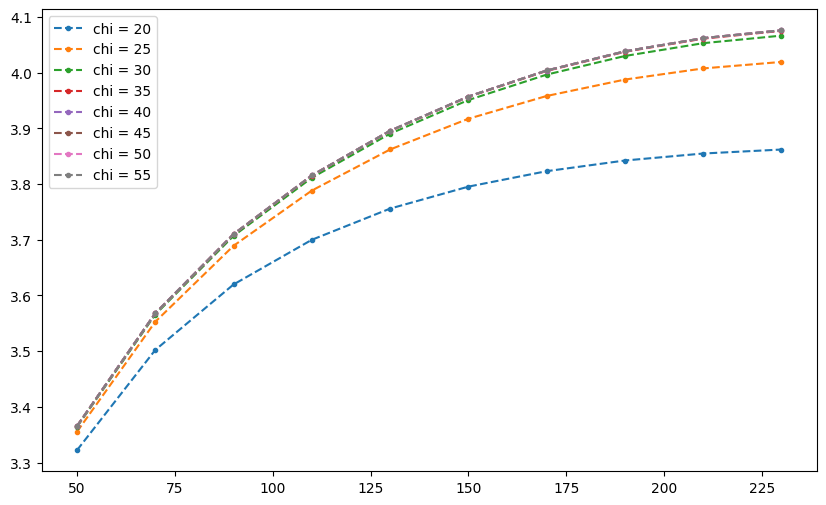

In [133]:
r_max = int(L/2)

plt.figure(figsize=(10,6))
for chi in chi_data:
    plt.plot([i for i in range(50, r_max,20)], [MPS_dict[chi].entropy(i) for i in range(50, r_max,20)], '.--', label = f'chi = {chi}')


plt.legend()

### Now lets look $S_E(L)$ for the Motzkin and JC chains

In [134]:
chi, t = [45, np.sqrt(np.pi)/7]
pL, pR = [.25,.25]
L = 550

A_JC = MPS_JC_2site(chi,t).conj().swapaxes(1,2)
A_Motz = A_Motzkin(chi, pL,pR)
BL = np.zeros((2, chi, chi))
BL[0,0,0] = 1


# JC tensor
MPS_list = [A_JC for i in range(L)]
MPS_list.insert(0, BL)
MPS_list.append(BL)

JC_MPS = MatrixProductState(MPS_list, shape = 'plr')
JC_MPS.cyclic = False
JC_MPS.normalize()

# Motzkin

MPS_list1 = [A_Motz for i in range(L)]
MPS_list1.insert(0, BL)
MPS_list1.append(BL)

Motz_MPS = MatrixProductState(MPS_list1, shape = 'plr')
Motz_MPS.cyclic = False
Motz_MPS.normalize()


0.02405163943505725

Let's look at the scaling of Motzkin $S_E$ compared to some ansatz $S_E(r) \sim \log(r(L-r)/L)$ 

In [135]:
L_data = np.arange(10, int(L/2)+1, 10)

Motz_SE = [Motz_MPS.entropy(L) for L in L_data.tolist()]
JC_SE = [JC_MPS.entropy(L) for L in L_data.tolist()]


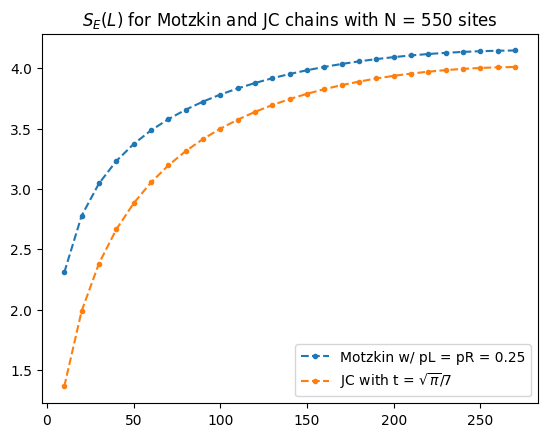

In [136]:
plt.figure()
plt.title(f"$S_E(L)$ for Motzkin and JC chains with N = {L} sites")

plt.plot(L_data,Motz_SE, '.--', label = f"Motzkin w/ pL = pR = {pL}")
plt.plot(L_data,JC_SE, '.--', label = "JC with t = $\sqrt{\pi}/7$")
plt.legend()

plt.show()

### Now lets fit the data

In [140]:
from scipy.optimize import curve_fit

def lin_fit(x,a,b):
    return a*x+b

fL_ansatz = np.log(L_data*(L-L_data)/L)

JC_fit = curve_fit(lin_fit, fL_ansatz, np.array(JC_SE), p0= [1/2,1])
Motz_fit = curve_fit(lin_fit, fL_ansatz, np.array(Motz_SE), p0= [1/2,1])

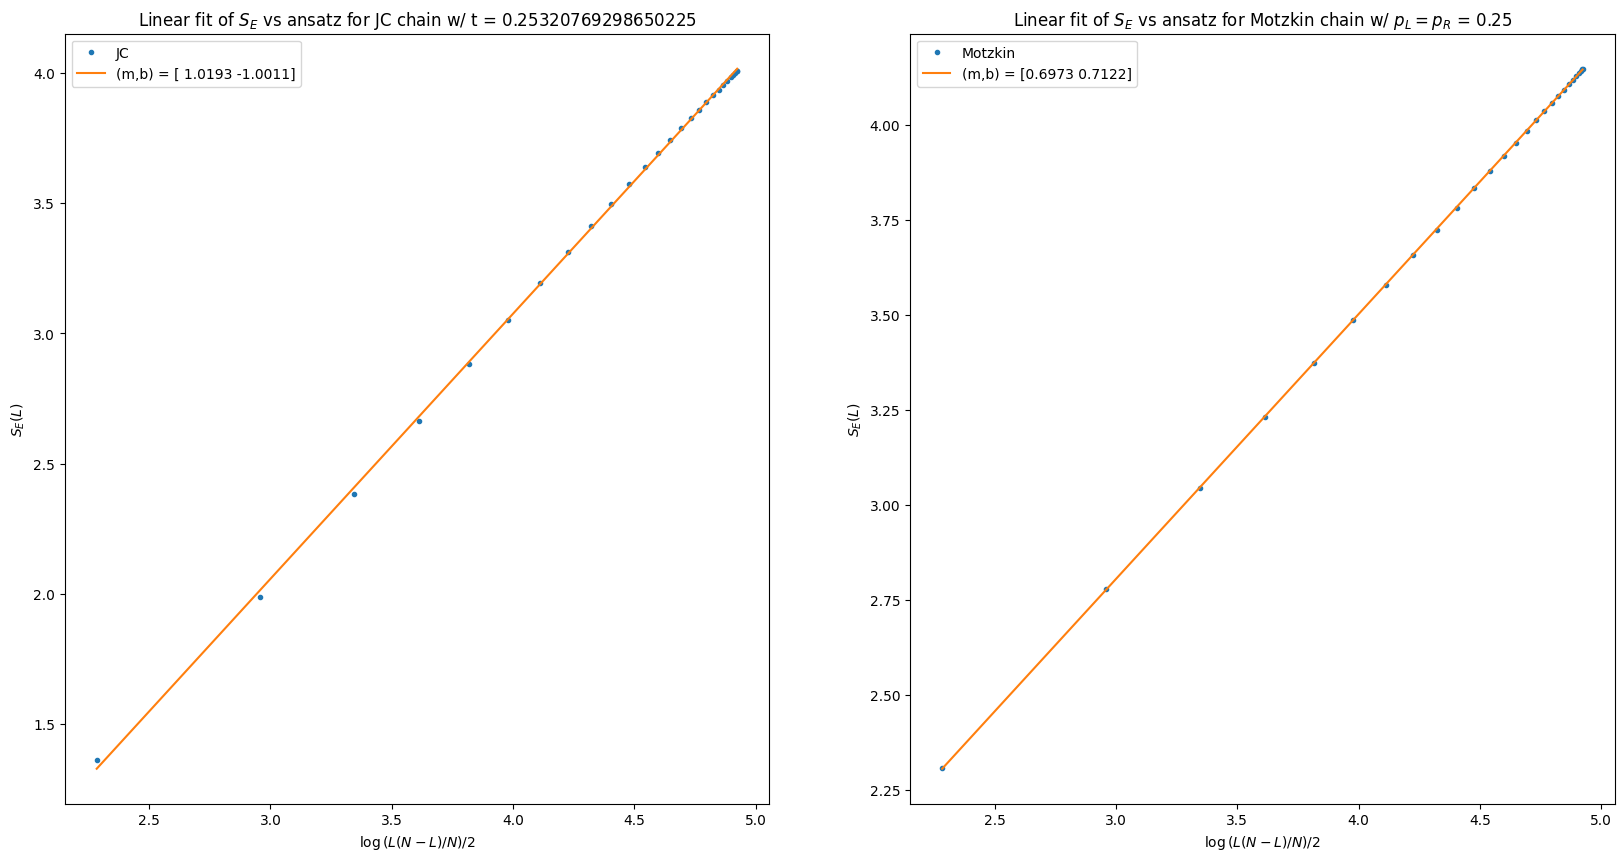

In [141]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))


ax1.plot(fL_ansatz.tolist(), JC_SE, '.', label = 'JC')
ax1.plot(fL_ansatz.tolist(), lin_fit(fL_ansatz, JC_fit[0][0], JC_fit[0][1]), label = f'(m,b) = {JC_fit[0].round(4)}')
ax1.set_title(f'Linear fit of $S_E$ vs ansatz for JC chain w/ t = {t}')
ax1.set_xlabel('$\log{(L(N-L)/N)}/2$')
ax1.set_ylabel('$S_E(L)$')
ax1.legend()

ax2.plot(fL_ansatz.tolist(), Motz_SE, '.', label = 'Motzkin')
ax2.plot(fL_ansatz.tolist(), lin_fit(fL_ansatz, Motz_fit[0][0], Motz_fit[0][1]), label = f'(m,b) = {Motz_fit[0].round(4)}')
ax2.set_title(f'Linear fit of $S_E$ vs ansatz for Motzkin chain w/ $p_L = p_R$ = {pL}')
ax2.set_xlabel('$\log{(L(N-L)/N)}/2$')
ax2.set_ylabel('$S_E(L)$')
ax2.legend()

plt.show()

## Correlation fcns:

In [139]:
Z_A, Z_B = [np.kron(pauli('Z'), np.eye(2)), np.kron(np.eye(2),pauli('Z'))]
X_A, X_B = [np.kron(pauli('X'), np.eye(2)), np.kron(np.eye(2),pauli('X'))]


In [143]:
JC_MPS.correlation(Z_A+Z_B, 20, 40)

(-0.0035704664544704964+1.7560802823238467e-34j)

In [ ]:
Z_ij_JC = [JC_MPS.correlation(Z_A+Z_B, 20, i) for i in range(20, int(L/2), 20)]